In [1]:
%pylab nbagg

import os
import functools

import h5py
import pyFAI

from collections import namedtuple
from typing import List, Tuple

from fabio.edfimage import edfimage
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, Goniometer
from pyFAI.gui import jupyter

import ipywidgets as widgets


# local import
from soleil import Angle, Calibrant, CalibrationMarsTxTz, CalibrationFunctions, CalibrationMarsTxTzFrame, DatasetPathContains, DatasetPathWithAttribute, \
    Detector, Length, Parameter, Wavelength, \
    DatasetPath, DatasetPathContains, DatasetPathWithAttribute, get_dataset,\
    calibration_mars_tx_tz, integrate_mars_tx_tz, save_as_edf_mars_tx_tz

Populating the interactive namespace from numpy and matplotlib


Il y a six types de fichiers à traiter.

nb images | tz      | poni
----------|---------|
5         |  -1     | x
5         |  0      | scan3.poni
5         |  x(-1)  | x
5         |  x(0)   | scan3.poni
1         |  -1     | x
1         |  0      | scan3.poni

In [2]:
ROOT = "/home/experiences/instrumentation/picca/jupyter/mars/20160800/"
PUBLISHED = os.path.join(ROOT, "published-data")

In [3]:
# do a calibration with a well centered sample.

# TODO recuperer le point de départ à partir des ponis de référence.
# TODO ajouter le diagramme complet à la fin.

json = os.path.join(PUBLISHED, "xrd", "calibration", "calibration.json")

distance = 0.258705917299
poni1_scale = 0  # TODO
poni1_offset = 0  # TODO
poni2_scale = 0.0012272727272727272
poni2_offset = -0.9488181818181818
rot1 = 0.00388272369359
rot2 = -0.00942588451226
rot3 = 7.19961198098e-07


functions = (
    CalibrationFunctions("dist",
                         "tz * poni1_scale + poni1_offset",
                         "tx * poni2_scale + poni2_offset",
                         "rot1",
                         "rot2",
                         "rot3"),    
    [Parameter[Length]("dist", distance, (distance-0.05, distance+0.05)),
     Parameter[float]("poni1_scale", poni1_scale, (poni1_scale-0.1, poni1_scale+0.1)),
     Parameter[Length]("poni1_offset", poni1_offset, (poni1_offset-1, poni1_offset+1)),
     Parameter[float]("poni2_scale", poni2_scale, (poni2_scale-0.1, poni2_scale+0.1)),
     Parameter[Length]("poni2_offset", poni2_offset, (poni2_offset-1, poni2_offset+1)),
     Parameter[Angle]("rot1", rot1, (rot1, rot1)),
     Parameter[float]("rot2", rot2, (rot2-0.1, rot2+0.1)),
     Parameter[Angle]("rot3", rot3, (rot3, rot3))]
)

# conserve the image available for calibration, remove others
def to_use(frame: CalibrationMarsTxTzFrame) -> bool:
   
    return True if frame.idx in range(0,30) else False

params = CalibrationMarsTxTz(os.path.join(PUBLISHED, "xrd", "calibration"),
                             os.path.join(ROOT, "scan_3_01.nxs"),
                             DatasetPathWithAttribute("interpretation", b"image"),  # images
                             DatasetPathContains("scan_data/actuator_1_1"),  # tx
                             0.0, # tz
                             # DatasetPathContains("MARS/D03-1-CX0__DT__DTC_2D-MT_Tz__#1/raw_value"),  # tz
                             [2, 5, 8],
                             to_use,
                             Calibrant("LaB6"),
                             Detector("xpad_flat"),
                             Wavelength(4.85945727522e-11),
                             functions
                            )

In [4]:
from functools import partial

def on_click_button(cmd, b):
    ! {cmd}
    
def my_cmd_button(cmd, description):
    # Click the button to open the data with silx
    button = widgets.Button(
        description=description,
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Click me',
        icon='check',
        layout = widgets.Layout(width='auto')
    )

    display(button)

    button.on_click(partial(on_click_button, cmd))

    return button

In [5]:
emacs = my_cmd_button("emacs soleil.py", "Edit the soleil.py file")

In [6]:
silx = my_cmd_button("silx view --use-opengl-plot " + params.filename,
                     'Silx View ' + os.path.basename(params.filename))

In [7]:
# save all the ref as images in order to do the calibration with
# pyFAI-calib[2].
# temporary until pyFAI-calib2 can read from NeXuS files.

cmds = save_as_edf_mars_tx_tz(params)
for cmd, idx in zip(cmds, params.idxs):
    my_cmd_button(cmd, 'PyFAI-calib2 ' + os.path.basename(params.filename) + " " + str(idx))

Empty refinement object:
GoniometerRefinement with 0 geometries labeled: .
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 4.859457e-11m
SampleDetDist= 2.568192e-01m	PONI= 1.379994e-01, -3.197165e-02m	rot1=0.008095  rot2= -0.028732  rot3= -0.000000 rad
DirectBeamDist= 256.934mm	Center: x=-261.928, y=1004.756 pix	Tilt=1.710 deg  tiltPlanRotation= -105.730 deg
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 4.859457e-11m
SampleDetDist= 2.591094e-01m	PONI= 1.322339e-01, 3.374004e-02m	rot1=0.008648  rot2= -0.007054  rot3= -0.000000 rad
DirectBeamDist= 259.126mm	Center: x=242.302, y=1003.123 pix	Tilt=0.639 deg  tiltPlanRotation= -140.794 deg
Detector Xpad S540 flat	 PixelSize= 1.300e-04, 1.300e-04 m
Wavelength= 4.859457e-11m
SampleDetDist= 2.593292e-01m	PONI= 1.310089e-01, 1.001319e-01m	rot1=0.010198  rot2= -0.002498  rot3= 0.000000 rad
DirectBeamDist= 259.343mm	Center: x=749.900, y=1002.778 pix	Tilt=0.602 deg  tiltPlanRotation= -166.238 deg
Fil

<IPython.core.display.Javascript object>


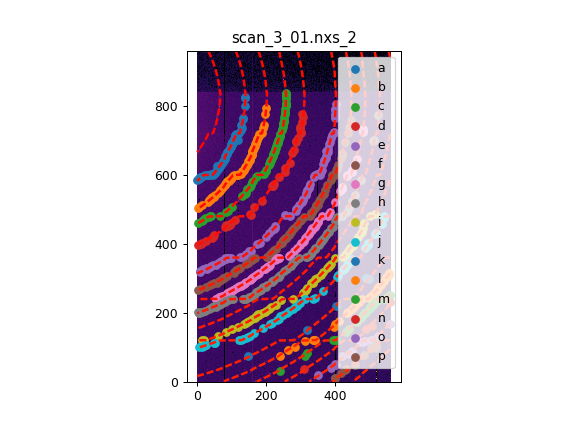

<IPython.core.display.Javascript object>


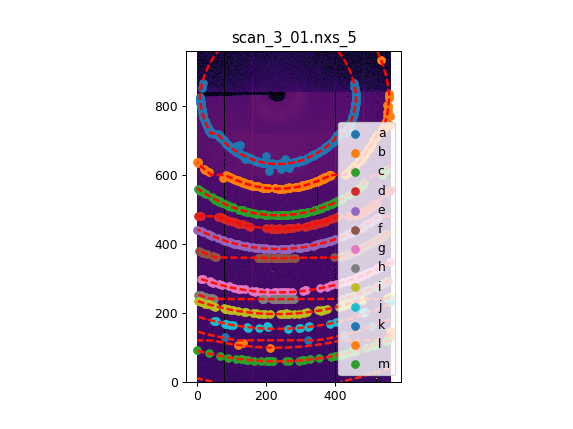

<IPython.core.display.Javascript object>


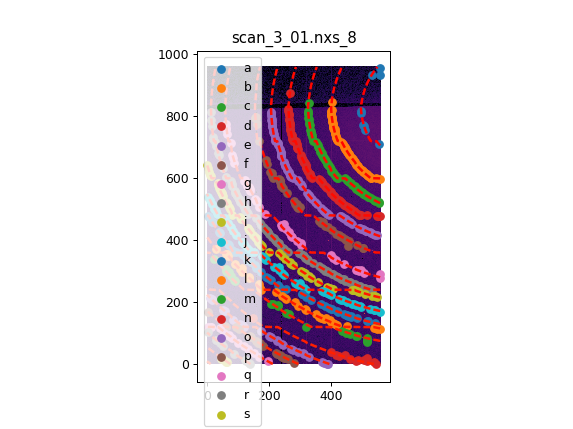

Cost function before refinement: 0.034913372764
[  2.58705917e-01   0.00000000e+00   0.00000000e+00   1.22727273e-03
  -9.48818182e-01   3.88272369e-03  -9.42588451e-03   7.19961198e-07]
     fun: 3.6471390887343777e-06
     jac: array([ -9.72309514e-05,   0.00000000e+00,   2.45397570e-04,
         1.84425589e-01,   1.64820585e-04,  -4.75197735e-05,
         1.42097602e-04,  -4.83169060e-13,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 258
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([  2.68185814e-01,   0.00000000e+00,   1.14273098e-01,
         1.02439091e-03,  -7.87270847e-01,   3.88272369e-03,
         6.40132736e-02,   7.19961198e-07])
Cost function after refinement: 3.64713908873e-06
GonioParam(dist=0.2681858135259898, poni1_scale=0.0, poni1_offset=0.11427309824048068, poni2_scale=0.0010243909112635302, poni2_offset=-0.78727084724419782, rot1=0.0038827236935899999, rot2=0.064013273602542081, rot3=7.1996119809799997e-07)
ma

<IPython.core.display.Javascript object>


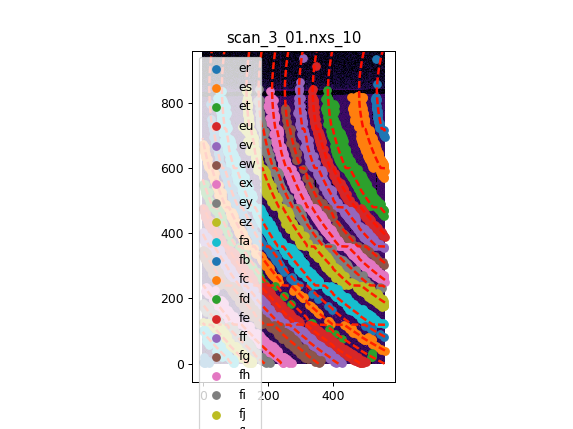

<IPython.core.display.Javascript object>


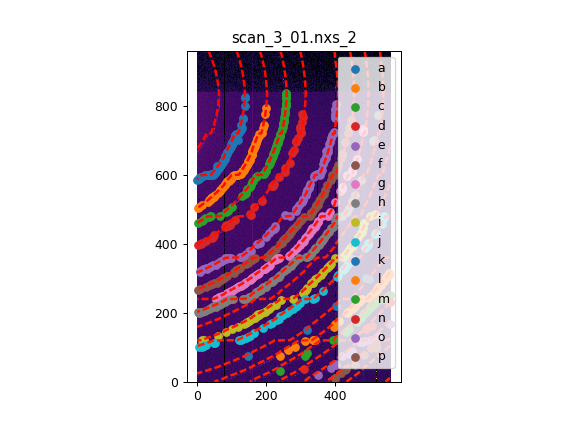

<IPython.core.display.Javascript object>


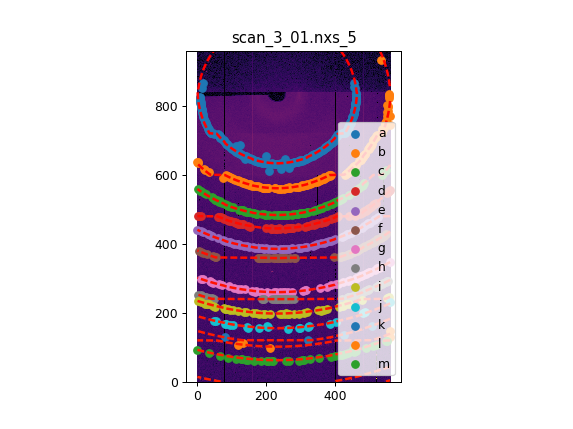

<IPython.core.display.Javascript object>


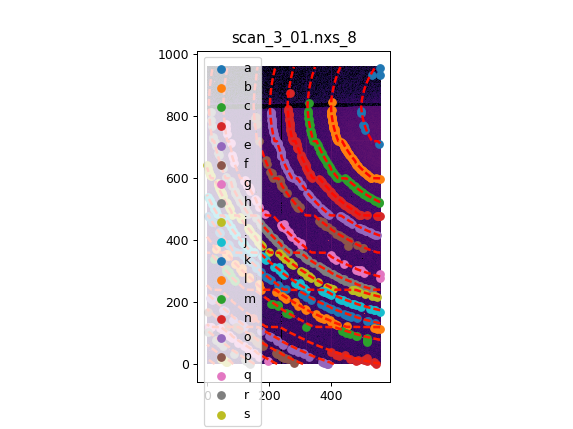

<IPython.core.display.Javascript object>


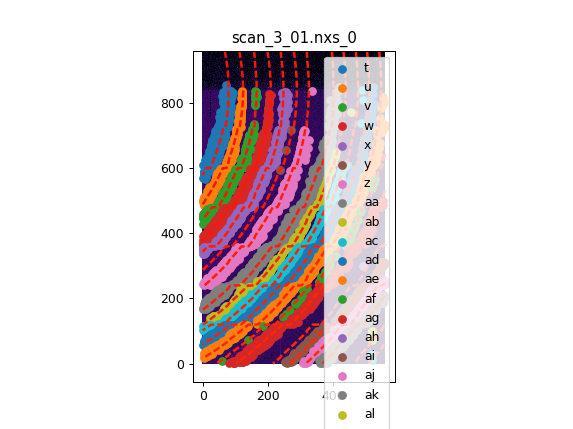

<IPython.core.display.Javascript object>


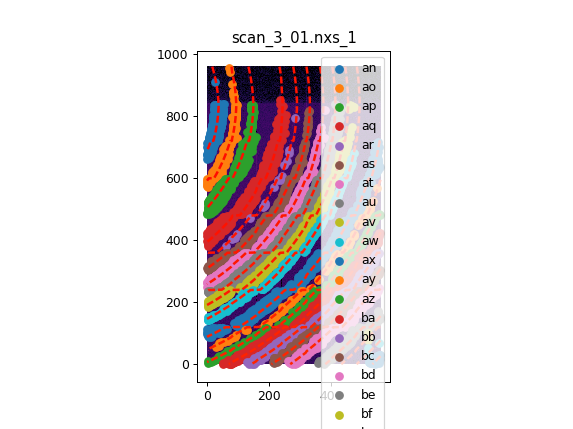

<IPython.core.display.Javascript object>


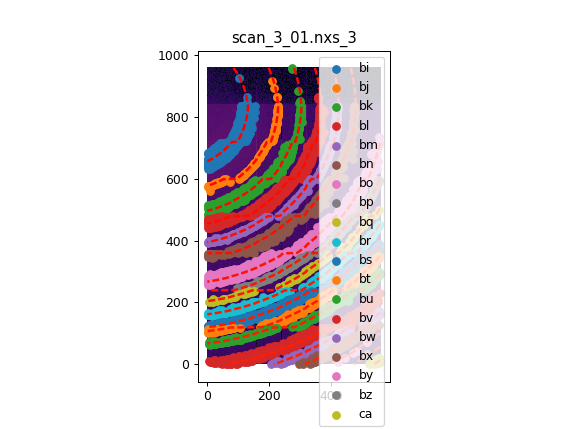

<IPython.core.display.Javascript object>


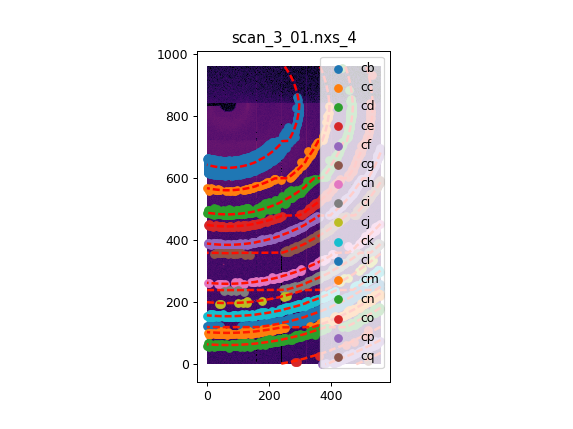

<IPython.core.display.Javascript object>


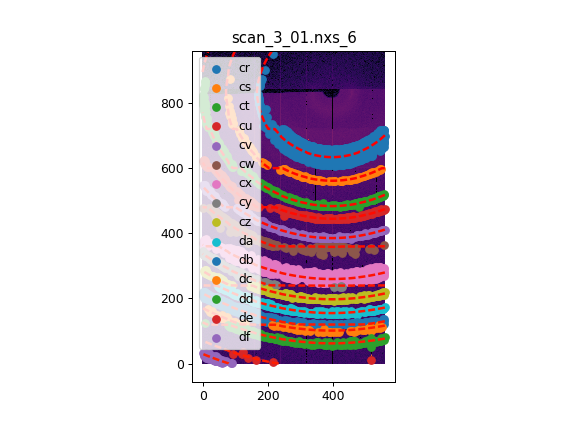

<IPython.core.display.Javascript object>


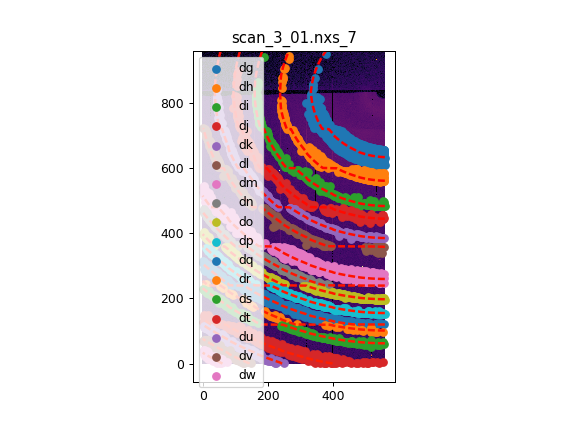

<IPython.core.display.Javascript object>


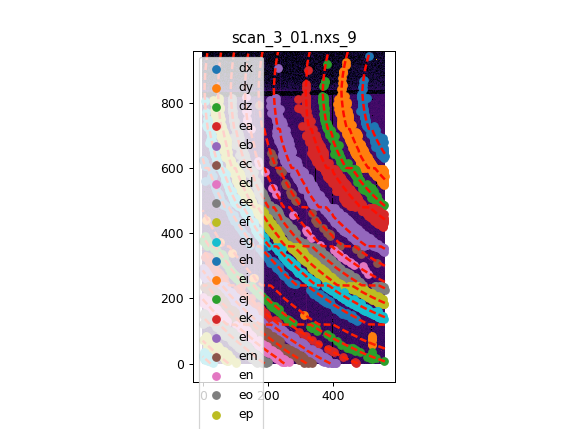

<IPython.core.display.Javascript object>


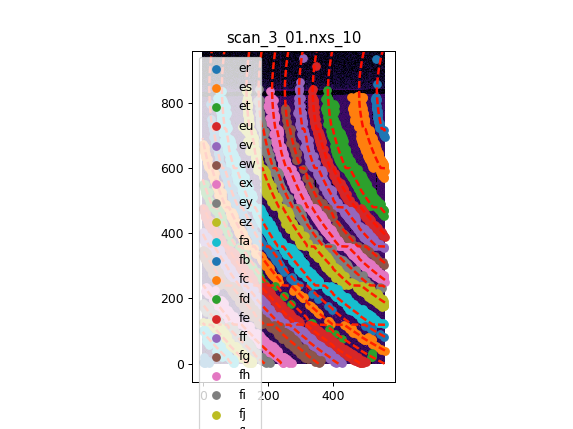

In [8]:
# execute the calibration

calibration_mars_tx_tz(json, params)

<IPython.core.display.Javascript object>


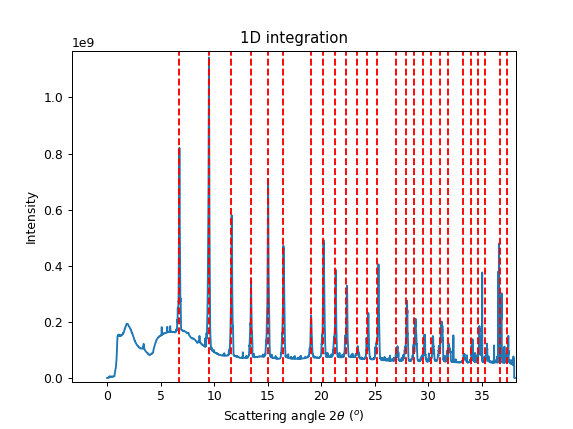

(array([  1.80000021e-03,   5.40000021e-03,   9.00000021e-03, ...,
          1.79991000e+02,   1.79994600e+02,   1.79998200e+02]),
 array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))

In [9]:
# plot the full diffractogram

def f(img: ndarray) -> ndarray:
    img = numpy.where(img > 20000, 0, img)
    return img

integrate_mars_tx_tz(json, params, f, plot_calibrant=True, n=50000)

In [ ]:
# il faudrait fair eune calibration avec l'ensemble des fichiers des scan3 et 4.
# scan3 10 images tx variant et tz=0.
# scan4 10 imagfes tx variant et tz = -1.

# TODO add the second scan for the calibration.
# TODO mask

In [9]:
# extraction des scans avec 6 positions en tx, quelque soit tz.
# CEs ont les seuls que nous pouvons traiter pour l'instant car
# la calibration n'a été faite que pour un tx de 6.
# LONG
import glob

files = glob.glob(os.path.join(ROOT, "*.nxs"))

def is_ok(filename: str) -> bool:
    with h5py.File(filename, mode='r') as f:
        for imgs, tx, tz in zip(get_images(f), get_tx(f), get_tz(f)):
            return True if tx.shape[0] == 6 else False

good = [f for f in files if is_ok(f)]
print(good)

NameError: name 'get_images' is not defined